# [모의 캐글 - 게임] 비매너 댓글 식별 

- 자연어 multi label classification 과제

참고 논문 : 
- [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)
- [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)

#### 최종 제출
- config = final_electra
- electra : beomi/KcELECTRA-base 이용
- logits 값이 아닌 prob = softmax(logits), prob값을 이용하여, loss 값 계산
- 맞춤법 검사, 한국어 아닌 문자들 삭제, 띄어쓰기 적용한 preprocessing
- 맞춤법 검사, 띄어쓰기 한번 더 적용(정교한 데이터 처리위해)
- title 제외하고, comment로만 모델 학습
- 가장 좋은 public값 획득 : 0.7743266

# 1. 환경 설정 및 라이브러리 불러오기

In [1]:
# !pip install -r requirements.txt

In [3]:
import pandas as pd
import os
import json
import numpy as np
import shutil

from sklearn.metrics import f1_score
from datetime import datetime, timezone, timedelta
import random
from tqdm import tqdm


from attrdict import AttrDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils import *
from torch.optim import Adam, AdamW

from transformers import logging, get_linear_schedule_with_warmup


from transformers import ( 
     BertConfig,
    ElectraConfig,
)

### v2 에서 라이브러리 추가됨
# 실험에 사용하실 모델 라이브러리를 추가하시는 걸 잊지 마세요!

from transformers import (
    BertTokenizer,  
    AutoTokenizer,
    ElectraTokenizer,
    RobertaTokenizer,
    AlbertTokenizer,
    RobertaTokenizerFast
)

from transformers import (
    BertModel,
    AutoModel, 
    ElectraForSequenceClassification,
    BertForSequenceClassification,
    RobertaForSequenceClassification,
    RobertaModel,
    AlbertForSequenceClassification
)


2022-03-06 04:42:48.046120: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
# 사용할 GPU 지정
print("number of GPUs: ", torch.cuda.device_count())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
use_cuda = torch.cuda.is_available()
print("Does GPU exist? : ", use_cuda)
DEVICE = torch.device("cuda" if use_cuda else "cpu")

number of GPUs:  1
Does GPU exist? :  True


In [5]:
# True 일 때 코드를 실행하면 example 등을 보여줌
DEBUG = True

In [6]:
# config 파일 불러오기
config_path = os.path.join('final_config.json')

def set_config(config_path):
    if os.path.lexists(config_path):
        with open(config_path) as f:
            args = AttrDict(json.load(f))
            print("config file loaded.")
            print(args.pretrained_model)
    else:
        assert False, 'config json file cannot be found.. please check the path again.'
    
    return args


# 코드 중간중간에 끼워넣어 리셋 가능
args = set_config(config_path)

# 결과 저장 폴더 미리 생성
os.makedirs(args.result_dir, exist_ok=True)
os.makedirs(args.config_dir, exist_ok=True)

config file loaded.
beomi/KcELECTRA-base


# 2. EDA 및 데이터 전처리

In [32]:
# data 경로 설정  
train_path = os.path.join(args.data_dir,'train.csv')

print("train 데이터 경로가 올바른가요? : ", os.path.lexists(train_path))


train 데이터 경로가 올바른가요? :  True


In [33]:
test_path = os.path.join(args.data_dir,'test.csv')
print("test 데이터 경로가 올바른가요? : ", os.path.lexists(test_path))

test 데이터 경로가 올바른가요? :  True


In [34]:
train_df = pd.read_csv(train_path, encoding = 'UTF-8-SIG')

train_df.head()

,title,comment,bias,hate
0,"""'미스터 션샤인' 변요한, 김태리와 같은 양복 입고 학당 방문! 이유는?""",김태리 정말 연기잘해 진짜,none,none
1,"""[SC현장]""""극사실주의 현실♥""""…'가장 보통의 연애' 김래원X공효진, 16년만...",공효진 발연기나이질생각이읍던데 왜계속주연일까,none,hate
2,"""손연재, 리듬체조 학원 선생님 """"하고 싶은 일 해서 행복하다""""""",누구처럼 돈만 밝히는 저급인생은 살아가지마시길~~ 행복은 머니순이 아니니깐 작은거에...,others,hate
3,"""'섹션TV' 김해숙 """"'허스토리' 촬영 후 우울증 얻었다""""""",일본 축구 져라,none,none
4,"""[단독] 임현주 아나운서 “‘노브라 챌린지’ 방송 덕에 낸 용기, 자연스런 논의의...",난 절대로 임현주 욕하는인간이랑은 안논다 @.@,none,none


In [10]:
test_df = pd.read_csv(test_path)
test_df.head()

,ID,title,comment
0,0,류현경 박성훈 공개연애 년차 애정전선 이상 의지 많이 된다 종합,둘 다 너무 좋다 행복하세요
1,1,현금 유도 인 라면 골목식당 백종원 초심 잃은 도시락집에 경악 종합,근데 만 원 이 하는 현금 결제만 하라고 써놓은 집 우리나라에 엄청 많은데
2,2,입대 서은광의 슬픈 멜로디 비투비 눈물의 첫 체조경기장 콘서트 종합,누군데 얘네
3,3,아이콘택트 리쌍 길 년 전 결혼설 부인한 이유 공개 결혼 출산 숨겼다,쇼 하지 마라 자식 아 음주 번은 실수 번은 고의 번은 인간 쓰레기 다 슬 금슬금 ...
4,4,구하라 안검하수 반박 해프닝 당당하다 그렇게까지 설전 종합,안검하수 가지고 있는 분께 희망을 주고 싶은 건가요 수술하면 이렇게 자연스러워진다고...


### 2-1 EDA

#### 1) 데이터 길이확인

Text(0, 0.5, 'Number of title')

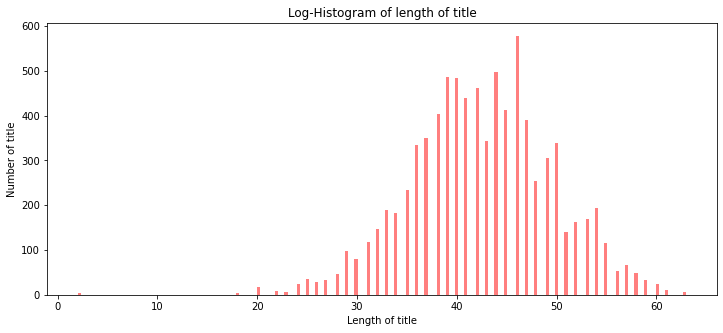

In [13]:
# train data 길이 시각화

train_title_length=train_df['title'].apply(len)
train_comment_length = train_df['comment'].apply(len)


# train_df['title'] 길이 확인

plt.figure(figsize=(12,5))
# 히스토그램 선언
# bins : 히스토그램 값에 대한 버킷 범위
# range : x축 값의 범위
# alpha : 그래프 색상 투명도
# color : 그래프 색상
# label : 그래프에 대한 라벨
plt.hist(train_title_length, bins=200, alpha=0.5, color='r', label='word')

# 그래프 제목
plt.title('Log-Histogram of length of title')
# 그래프 x축 라벨
plt.xlabel('Length of title')
# 그래프 y축 라벨
plt.ylabel('Number of title')

Text(0, 0.5, 'Number of comment')

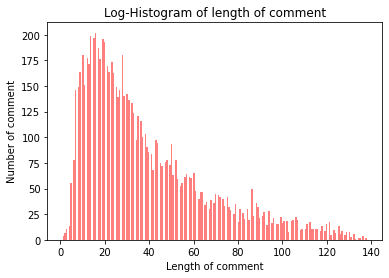

In [15]:
plt.hist(train_comment_length, bins=200, alpha=0.5, color='r', label='word')

# 그래프 제목
plt.title('Log-Histogram of length of comment')
# 그래프 x축 라벨
plt.xlabel('Length of comment')
# 그래프 y축 라벨
plt.ylabel('Number of comment')

#### 2) 데이터 이상치 확인

In [16]:
print('댓글 길이 최댓값:', f'{np.max(train_comment_length)}')
print('댓글 길이 최솟값:', f'{np.min(train_comment_length)}')
print('댓글 길이 평균값:', f'{np.mean(train_comment_length):2f}')
print('댓글 길이 표준편차:', f'{np.std(train_comment_length):2f}')
print('댓글 길이 중간값:', f'{np.median(train_comment_length)}')
print('댓글 길이 제1사분위:', f'{np.percentile(train_comment_length,25)}')
print('댓글 길이 제3사분위:', f'{np.percentile(train_comment_length,75)}')

댓글 길이 최댓값: 138
댓글 길이 최솟값: 1
댓글 길이 평균값: 38.714234
댓글 길이 표준편차: 27.963382
댓글 길이 중간값: 30.0
댓글 길이 제1사분위: 18.0
댓글 길이 제3사분위: 52.0


In [17]:
print('기사 제목 길이 최댓값:', f'{np.max(train_title_length)}')
print('기사 제목 길이 최솟값:', f'{np.min(train_title_length)}')
print('기사 제목 길이 평균값:', f'{np.mean(train_title_length):2f}')
print('기사 제목 길이 표준편차:', f'{np.std(train_title_length):2f}')
print('기사 제목 길이 중간값:', f'{np.median(train_title_length)}')
print('기사 제목 길이 제1사분위:', f'{np.percentile(train_title_length,25)}')
print('기사 제목 길이 제3사분위:', f'{np.percentile(train_title_length,75)}')

기사 제목 길이 최댓값: 63
기사 제목 길이 최솟값: 2
기사 제목 길이 평균값: 42.484164
기사 제목 길이 표준편차: 7.082178
기사 제목 길이 중간값: 42.0
기사 제목 길이 제1사분위: 38.0
기사 제목 길이 제3사분위: 47.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f4071d88460>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4071d88ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4071d88190>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4071d88fa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4071d95580>],
 'means': [<matplotlib.lines.Line2D at 0x7f4071d952b0>]}

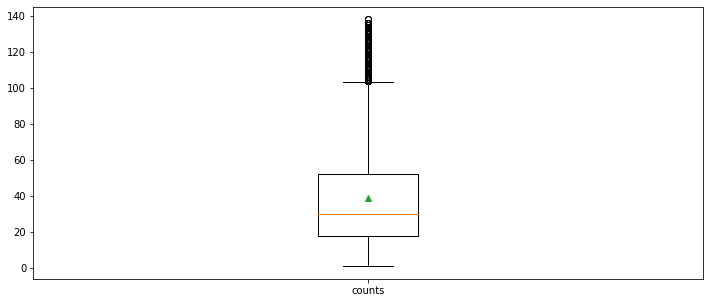

In [18]:
plt.figure(figsize=(12,5))
plt.boxplot(train_comment_length,
           labels=['counts'],
           showmeans=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4071d751f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4071d75790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4071d75040>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4071d75d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4071d82310>],
 'means': [<matplotlib.lines.Line2D at 0x7f4071d82040>]}

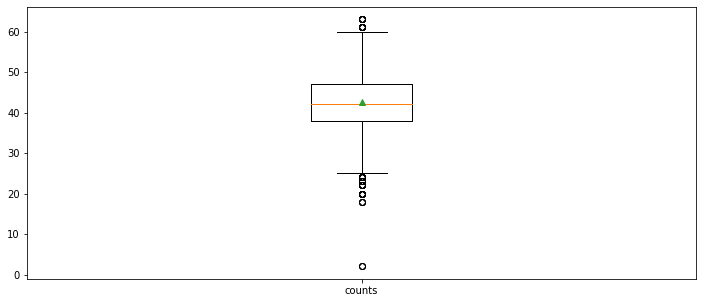

In [19]:
plt.figure(figsize=(12,5))
plt.boxplot(train_title_length,
           labels=['counts'],
           showmeans=True)

#### 3) wordcloud 이용해서 사용빈도 높은 단어 확인

In [26]:
from wordcloud import WordCloud

(-0.5, 799.5, 599.5, -0.5)

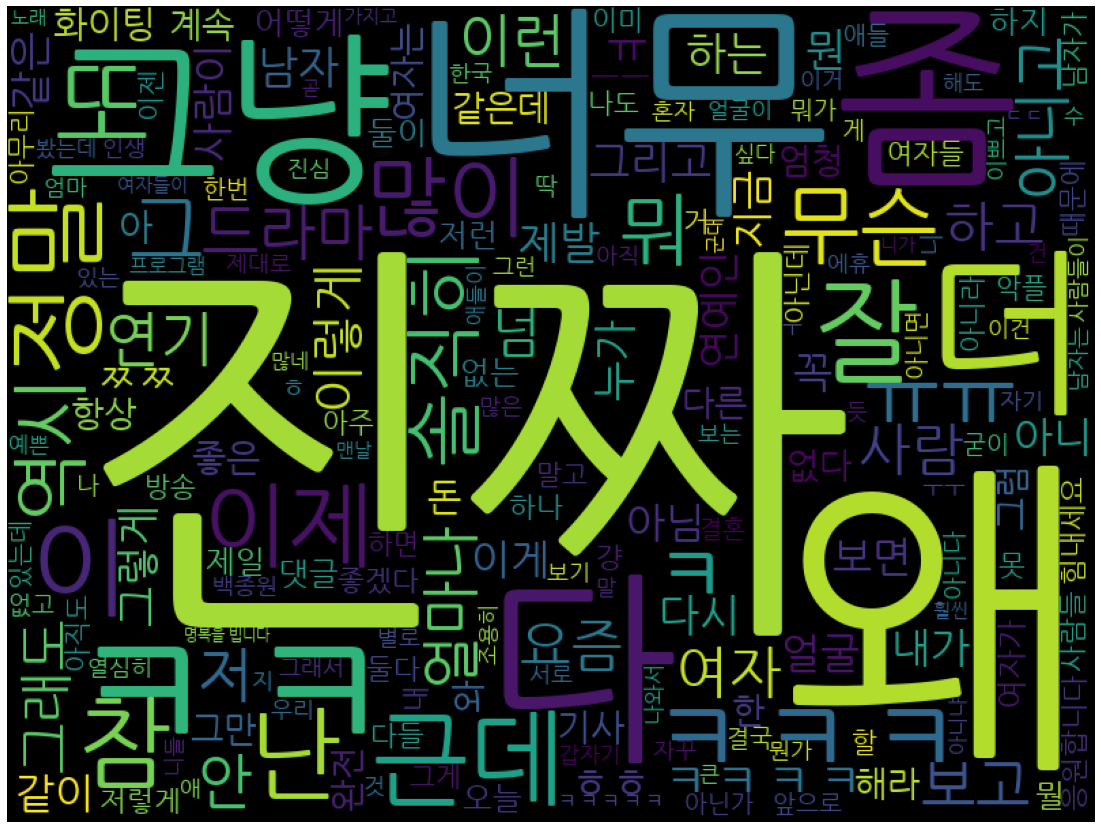

In [35]:
Cloud = WordCloud(font_path ='./NanumGothic.ttf', width=800,height=600).generate(" ".join(train_df['comment']))
plt.figure(figsize=(20,15))
plt.imshow(Cloud)
plt.axis('off')

### 2-2 데이터 전처리

In [9]:
# 띄어쓰기, 문자 제외하고 제거하기 (EX.숫자 한문)

import re
def extract_word(text):
    hangul = re.compile('[^가-힣]') 
    result = hangul.sub(' ', text) 
    return result

train_df['title'] = train_df['title'].apply(lambda x:extract_word(x))
train_df["comment"] = train_df['comment'].apply(lambda x:extract_word(x))

In [10]:
test_df['title'] = test_df['title'].apply(lambda x:extract_word(x))
test_df["comment"] = test_df['comment'].apply(lambda x:extract_word(x))

In [11]:
train_df.head()

,title,comment,bias,hate
0,미스터 션샤인 변요한 김태리와 같은 양복 입고 학당 방문 이유는,김태리 정말 연기잘해 진짜,none,none
1,현장 극사실주의 현실 가장 보통의 연애 김래원 공효진 년만...,공효진 발연기나이질생각이읍던데 왜계속주연일까,none,hate
2,손연재 리듬체조 학원 선생님 하고 싶은 일 해서 행복하다,누구처럼 돈만 밝히는 저급인생은 살아가지마시길 행복은 머니순이 아니니깐 작은거에...,others,hate
3,섹션 김해숙 허스토리 촬영 후 우울증 얻었다,일본 축구 져라,none,none
4,단독 임현주 아나운서 노브라 챌린지 방송 덕에 낸 용기 자연스런 논의의...,난 절대로 임현주 욕하는인간이랑은 안논다,none,none


In [12]:
#!pip install konlpy

     |████████████████████████████████| 19.4 MB 19.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 32.8 MB/s eta 0:00:01


In [13]:
# from konlpy.tag import Okt 
# okt = Okt()

# for i, sentence in enumerate(train_df["comment"]):
#     train_df['comment'][i] = okt.normalize(sentence)
    
# for i, sentence in enumerate(test["comment"]):
#     train_df['comment'][i] = okt.normalize(sentence)

JVMNotFoundException: No JVM shared library file (libjvm.so) found. Try setting up the JAVA_HOME environment variable properly.

In [16]:
# !pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-7yokwu42
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4853 sha256=aa4a5342ff5917795458de980807608d78392035c176eaa043ad3878e2621688
  Stored in directory: /tmp/pip-ephem-wheel-cache-lkife7j2/wheels/3f/a5/73/e4d2806ae141d274fdddaabf8c0ed79be9357d36bfdc99e4b4
Successfully built py-hanspell


In [ ]:
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [13]:
# 맞춤법 겁사기 작동 (train data)
# 추후 모델에서 title은 사용하지 않을 예정
from hanspell import spell_checker
 
for i, sentence in enumerate(train_df["comment"]):
    spelled_sent = spell_checker.check(sentence)
    train_df["comment"][i] = spelled_sent.checked

In [14]:
# 맞춤법 겁사기 작동 (test data)
# 추후 모델에서 title은 사용하지 않을 예정
for i, sentence in enumerate(test_df["comment"]):
    spelled_sent = spell_checker.check(sentence)
    test_df["comment"][i] = spelled_sent.checked

/tmp/ipykernel_108319/2167164586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["comment"][i] = spelled_sent.checked


In [8]:
# 띄어쓰기 (train data)
# 추후 모델에서 title은 사용하지 않을 예정
from pykospacing import Spacing
spacing = Spacing()

for i, sentence in enumerate(train_df["comment"]):
    train_df["comment"][i] = spacing(sentence)
    

2022-03-03 01:05:13.118659: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-03 01:05:13.119788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-03-03 01:05:13.119843: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-03 01:05:13.119880: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-03 01:05:13.119900: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-03-03 01:05:13.119920: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2022-0

In [9]:
# 띄어쓰기 (test data)
# 추후 모델에서 title은 사용하지 않을 예정
for i, sentence in enumerate(test_df["comment"]):
    test_df["comment"][i] = spacing(sentence)    

/tmp/ipykernel_108319/207517926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["comment"][i] = spacing(sentence)


In [ ]:
# 맞춤법 겁사기 한번 더 작동

from hanspell import spell_checker
 
for i, sentence in enumerate(train_df["comment"]):
    spelled_sent = spell_checker.check(sentence)
    train_df["comment"][i] = spelled_sent.checked
    
for i, sentence in enumerate(test_df["comment"]):
    spelled_sent = spell_checker.check(sentence)
    test_df["comment"][i] = spelled_sent.checked

In [ ]:
# 띄어쓰기 한번 더 작동 
from pykospacing import Spacing
spacing = Spacing()

for i, sentence in enumerate(train_df["comment"]):
    train_df["comment"][i] = spacing(sentence)
for i, sentence in enumerate(test_df["comment"]):
    test_df["comment"][i] = spacing(sentence)    

In [12]:
test_df

,ID,title,comment
0,0,류현경 박성훈 공개연애 년차 애정전선 이상 의지 많이 된다 종합,둘 다 너무 좋다 행복하세요
1,1,현금 유도 인 라면 골목식당 백종원 초심 잃은 도시락집에 경악 종합,근데 만 원 이 하는 현금 결제만 하라고 써놓은 집 우리나라에 엄청 많은데
2,2,입대 서은광의 슬픈 멜로디 비투비 눈물의 첫 체조경기장 콘서트 종합,누군데 얘네
3,3,아이콘택트 리쌍 길 년 전 결혼설 부인한 이유 공개 결혼 출산 숨겼다,쇼 하지 마라 자식 아 음주 번은 실수 번은 고의 번은 인간 쓰레기 다 슬 금슬금 ...
4,4,구하라 안검하수 반박 해프닝 당당하다 그렇게까지 설전 종합,안검하수 가지고 있는 분께 희망을 주고 싶은 건가요 수술하면 이렇게 자연스러워진다고...
...,...,...,...
506,506,이슈 최율 조재현 성추행 의혹 폭로 소속사 상황 파악 중,얜 그냥 봐도 아니다 고소당하면 어 마어마한 금액 물어줘야 할 걸
507,507,해투 이서진 한지민 대본 리딩 격리설 해명 날씨가 좋아서 컷,대박 게스트 꼭 봐야지 콘셉트가 바뀌니깐 재미 지네
508,508,인터뷰 박민영 김비서 행복했다 열애설엔 당당 미소였으니까,성형으로 다 뜯어고쳐 놓고 예쁜 척 성형 전 네 얼굴 다 알고 있다 순자처럼 된 장...
509,509,이슈 사실무근 캐슬 측 위올라이 표절설 부인 여전히 핫 종합,분위기는 비슷하다 만 전혀 다른 전개 던데 무슨 우리나라 사람들은 분위기만 비슷하면...


In [15]:
# 전처리한 데이터 csv저장
train_df.to_csv('./data/amended_train+.csv', index=False)
test_df.to_csv('./data/amended_test+.csv', index=False)

In [19]:
test_df.head(10)

,ID,title,comment
0,0,류현경 박성훈 공개연애 년차 애정전선 이상 의지 많이 된다 종합,둘 다 너무 좋다 행복하세요
1,1,현금 유도 인 라면 골목식당 백종원 초심 잃은 도시락집에 경악 종합,근데 만 원 이하는 현금 결제만 하라고 써놓은 집 우리나라에 엄청 많은데
2,2,입대 서은광의 슬픈 멜로디 비투비 눈물의 첫 체조경기장 콘서트 종합,누군데 얘네
3,3,아이콘택트 리쌍 길 년 전 결혼설 부인한 이유 공개 결혼 출산 숨겼다,쇼하지 마라 자식 아 음주 번은 실수 번은 고의 번은 인간쓰레기 다 슬 금슬은 기어...
4,4,구하라 안검하수 반박 해프닝 당당하다 그렇게까지 설전 종합,안검하수 가지고 있는 분께 희망을 주고 싶은 건가요 수술하면 이렇게 자연스러워진다고...
5,5,팝인터뷰 이세영 화유기 참 아픈 작품 더 나은 환경 기대해,그건 불가능해 그냥 은퇴해서 평범하게 살아라 언제가 될지는 모르지만 시기가 문제 일...
6,6,리뷰 골목식당 신흥시장 변화 이끈 백종원의 진심,골목 살리고 지각하는 체인 점 다 입점해서 때 돈 벌고 피디 술 사주고 지가 음식점...
7,7,현아 이던 열애 그후 팬 위한 배려는 어디로,근데 팬들이 나서야 되는데 왜 일반인들이 연애할 수도 있지 이임 내가 봐도 팬들 개...
8,8,장동윤 운명적 배우 데뷔 인생작 녹두전 만나기까지 종합,여자 같다 어깨도 너무 좁고 뜨긴 글렀네
9,9,현장 연예인 인생 협박 유감 미소잃은 최민수 보복운전 혐의 차 공판...,좋게 좋게 해결되시길


### 2-3. 데이터 확인

In [20]:
### v2 에서 추가됨

# title 중 가장 긴 타이틀 길이
max_len_title = np.max(train_df['title'].str.len())
max_len_title

63

In [21]:
# comment 중 가장 긴 타이틀 길이
max_len_comment=np.max(train_df['comment'].str.len())
max_len_comment

137

In [22]:
# 길이가 128이 넘는 코멘트 확인
train_df['comment'][train_df['comment'].str.len()>128]

136     진짜 연기 못하는 애들만 모아뒀네 월 화 드라마가 시청률 똥 마이라 드라마 잠정 폐...
170     개 쳐 늙으면 꼴 보기 싫어지는 게 사람의 마음이 지 얘네야 광고 수익으로 번 게 ...
256     남자 지갑 꺼내 어쩌 네 말 많은데 쟤 갤러리아 포레사는 데 한국에서 위권 안에 드...
359     이름도 몰라 얼굴도 몰라 너희들만의 정신 승리로 한류인 척 쇼하라고 문재인 탄핵 위...
424     쿵쾅 잎들아 너네가 알아야 할 게 눈코 입 윤곽 다 해도 겨우 중 마치 든가 다 해...
657     수아가 불쌍하다 납치돼서 년을 힘들게 살고 남자 놈은 수아 버리고 민 채린한테 가서...
728     남자로서 혜나 보면 미혼모의 낙태는 필요한 듯 엄마 사랑받고 자랐지만 결국 그 존재...
1437    그냥 좀 착하게 살면 안 되겠냐 여기다가 설정이 네 어쩌 네 썰 전 펼치면서 애 하...
1609    역시 힙합은 마약과 떨어질 수 없는 자르지 그만큼 한국 오버 힙합은 가 책임지고 있...
1643    세 가족 모두 짠했지만 반듯하게 잘 크고 있는 건 아빠의 빈자리를 엄마의 역할이 배...
1929    두 분 가정살이에 왜 남들이 이래저래 하는지 그런 면 두 분이 일반이면 저렇게까지 ...
2066    솔직히 남자들 사이에서 저런 거 올리면 욕하기도 그렇고 좀 가만있게 될 거 같다로 ...
2655    내가 너를 고소하고 싶어 정국 아 진짜 존 나 패고 싶다 생각이 없니 국뽕으로 뭘 ...
2702    사장들 긴장해서 인터뷰 장소에서 지적당하는 화면 보며 더 우울해하는데 옆에 조보아 ...
3068    솔까 마다 욕하는 인간들 치고 돈 안 떼인 인간 없지 싶다 안 그러고는 불구대천 원...
3386    우하 하 키 득 어쩌면 좋아 일본에서 활동할 팀은 이제부터 느 아이지원이 당 여러분...
3572    무안주 고 개 쪽 중 건지면서 무슨 상처 물론 고장환이 잘못한 건 맞지만 딱 상상이...
3627    고현정 비 

In [23]:
len(train_df)

8367

In [36]:
print("bias classes: ", train_df.bias.unique())
print("hate classes: ", train_df.hate.unique())

bias classes:  ['none' 'others' 'gender']
hate classes:  ['none' 'hate']


In [37]:
pd.crosstab(train_df.bias, train_df.hate, margins=True)

hate,hate,none,All
bias,,,
gender,1216,83,1299
none,2068,3422,5490
others,1437,141,1578
All,4721,3646,8367


In [38]:
len(test_df)

511

### 2-3. 데이터 전처리 (Label Encoding)
bias, hate 라벨들의 class를 정수로 변경하여 라벨 인코딩을 하기 위한 딕셔너리입니다.

- bias, hate 컬럼을 합쳐서 하나의 라벨로 만들기 

In [39]:
# 두 라벨의 가능한 모든 조합 만들기
combinations = np.array(np.meshgrid(train_df.bias.unique(), train_df.hate.unique())).T.reshape(-1,2)

if DEBUG==True:
    print(combinations)

[['none' 'none']
 ['none' 'hate']
 ['others' 'none']
 ['others' 'hate']
 ['gender' 'none']
 ['gender' 'hate']]


In [40]:
# bias, hate 컬럼을 합친 것
bias_hate = list(np.array([train_df['bias'].values, train_df['hate'].values]).T.reshape(-1,2))

if DEBUG==True:
    print(bias_hate[:5])


[array(['none', 'none'], dtype=object), array(['none', 'hate'], dtype=object), array(['others', 'hate'], dtype=object), array(['none', 'none'], dtype=object), array(['none', 'none'], dtype=object)]


In [41]:
labels = []
for i, arr in enumerate(bias_hate):
    for idx, elem in enumerate(combinations):
        if np.array_equal(elem, arr):
            labels.append(idx)

train_df['label'] = labels
train_df.head()

,title,comment,bias,hate,label
0,미스터 션샤인 변요한 김태리와 같은 양복 입고 학당 방문 이유는,김태리 정말 연기 잘해 진짜,none,none,0
1,현장 극사실주의 현실 가장 보통의 연애 김래원 공효진 년만...,공효진 발 연기나 이 질 생각이 없던데 왜 계속 주연일까,none,hate,1
2,손연재 리듬체조 학원 선생님 하고 싶은 일 해서 행복하다,누구처럼 돈만 밝히는 저급 인생은 살아가지 마시길 행복은 머니 순이 아니니깐 작은 ...,others,hate,3
3,섹션 김해숙 허스토리 촬영 후 우울증 얻었다,일본 축구 져라,none,none,0
4,단독 임현주 아나운서 노브라 챌린지 방송 덕에 낸 용기 자연스런 논의의...,난 절대로 임현주 욕하는 인간이랑은 안 논 다,none,none,0


## 3. Dataset 로드

### 3-0. Pre-trained tokenizer 탐색

In [42]:
# config.json 에서 지정 이름별로 가져올 라이브러리 지정

TOKENIZER_CLASSES = {
    "BertTokenizer": BertTokenizer,
    "AutoTokenizer": AutoTokenizer,
    "ElectraTokenizer": ElectraTokenizer,
    "RobertaTokenizer": RobertaTokenizer,
    "RobertaTokenizerFast":RobertaTokenizerFast
}


- Tokenizer 사용 예시

In [43]:
TOKENIZER = TOKENIZER_CLASSES[args.tokenizer_class].from_pretrained(args.pretrained_model)
if DEBUG==True:
    print(TOKENIZER)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'ElectraTokenizer'.


PreTrainedTokenizer(name_or_path='beomi/KcELECTRA-base', vocab_size=50135, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [44]:
if DEBUG == True:
    example = train_df['title'][1]
    comment_ex = train_df['comment'][1]
    print(TOKENIZER(example, comment_ex))

{'input_ids': [2, 13583, 364, 10505, 8070, 8469, 8546, 10730, 4041, 14361, 394, 4097, 4195, 275, 45812, 681, 12064, 1224, 4055, 4232, 18398, 3, 275, 45812, 1628, 11061, 4075, 2741, 3008, 8896, 14188, 4055, 2607, 8247, 29878, 9770, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [45]:
if DEBUG==True:
    print(TOKENIZER.encode(example),"\n")
    
    # 토큰으로 나누기
    print(TOKENIZER.tokenize(example),"\n")
    
    # 토큰 id로 매핑하기
    print(TOKENIZER.convert_tokens_to_ids(TOKENIZER.tokenize(example)))


[2, 13583, 364, 10505, 8070, 8469, 8546, 10730, 4041, 14361, 394, 4097, 4195, 275, 45812, 681, 12064, 1224, 4055, 4232, 18398, 3] 

['현장', '극', '##사실', '##주의', '현실', '가장', '보통', '##의', '연애', '김', '##래', '##원', '공', '##효진', '년', '##만의', '랑', '##데', '##부', '종합'] 

[13583, 364, 10505, 8070, 8469, 8546, 10730, 4041, 14361, 394, 4097, 4195, 275, 45812, 681, 12064, 1224, 4055, 4232, 18398]


### 3-1. Dataset 만드는 함수 정의

In [46]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len, mode = 'train'):

        self.data = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.mode = mode
        
        if self.mode!='test':
            try: 
                self.labels = df['label'].tolist()
            except:
                assert False, 'CustomDataset Error : \'label\' column does not exist in the dataframe'
     
    def __len__(self):
        return len(self.data)
                

    def __getitem__(self, idx):
        """
        전체 데이터에서 특정 인덱스 (idx)에 해당하는 기사제목과 댓글 내용을 
        토크나이즈한 data('input_ids', 'attention_mask','token_type_ids')의 딕셔너리 형태로 불러옴
        """
        # title = self.data.title.iloc[idx] -> title을 제외하기로 결정
        comment = self.data.comment.iloc[idx]
        
        tokenized_text = self.tokenizer(comment, #title
                             padding= 'max_length',
                             max_length=self.max_len,
                             truncation=True,
                             return_token_type_ids=True,
                             return_attention_mask=True,
                             return_tensors = "pt")
        
        data = {'input_ids': tokenized_text['input_ids'].clone().detach().long(),
               'attention_mask': tokenized_text['attention_mask'].clone().detach().long(),
               'token_type_ids': tokenized_text['token_type_ids'].clone().detach().long(),
               }
        
        if self.mode != 'test':
            label = self.data.label.iloc[idx]
            return data, label
        else:
            return data
        

    
train_dataset = CustomDataset(train_df, TOKENIZER, args.max_seq_len, mode ='train')
print("train dataset loaded.")

train dataset loaded.


In [47]:
if DEBUG ==True :
    print("dataset sample : ")
    print(train_dataset[0])

dataset sample : 
({'input_ids': tensor([[    2, 20778,  4177,  8057, 11061, 12751,  7997,     3,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,    

In [48]:
# encoded_plus = tokenizer.encode_plus(
#                     sentence,                      # Sentence to encode.
#                     add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                     max_length = 128,           # Pad & truncate all sentences.
#                     pad_to_max_length = True,
#                     return_attention_mask = True,   # Construct attention masks.
#                     return_tensors = 'pt',     # Return pytorch tensors.
#                )

### 3-2. Train, Validation set 나누기

In [49]:
from sklearn.model_selection import train_test_split
                                                         
train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=args.seed)

train_dataset = CustomDataset(train_data, TOKENIZER, args.max_seq_len, 'train')
val_dataset = CustomDataset(val_data, TOKENIZER, args.max_seq_len, 'validation')

print("Train dataset: ", len(train_dataset))
print("Validation dataset: ", len(val_dataset))

Train dataset:  7530
Validation dataset:  837


## 4. 분류 모델 학습을 위한 세팅

### 4-1. 아키텍쳐 설정




- [PretrainedConfig](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/configuration#transformers.PretrainedConfig.from_pretrained)
-[KcELECTRA 사전학습 모델](https://github.com/Beomi/KcELECTRA)

In [50]:
from transformers import logging
logging.set_verbosity_error()

# config.json 에 입력된 architecture 에 따라 베이스 모델 설정
BASE_MODELS = {
    "BertForSequenceClassification": BertForSequenceClassification,
    "AutoModel": AutoModel,
    "ElectraForSequenceClassification": ElectraForSequenceClassification,
    "AlbertForSequenceClassification": AlbertForSequenceClassification,
    "RobertaForSequenceClassification": RobertaForSequenceClassification
    

}


myModel = BASE_MODELS[args.architecture].from_pretrained(args.pretrained_model, 
                                                         num_labels = args.num_classes, 
                                                         output_attentions = False, # Whether the model returns attentions weights.
                                                         output_hidden_states = True, # Whether the model returns all hidden-states.
                                                        ignore_mismatched_sizes=True)
if DEBUG==True:
    # 모델 구조 확인
    print(myModel)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(50135, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

### 4-2. 모델 설정


- BertForSequenceClassifier (line 1232부터 참고) [source code](https://github.com/huggingface/transformers/blob/a39dfe4fb122c11be98a563fb8ca43b322e01036/src/transformers/modeling_bert.py#L1284-L1287)

- ElectraForSequenceClassifier [source code](https://huggingface.co/transformers/v3.0.2/_modules/transformers/modeling_electra.html#ElectraForSequenceClassification)

- SequenceClassier output 형태 : tuple(torch.FloatTensor)
    - loss (torch.FloatTensor of shape (1,), optional, returned when label is provided):
    Classification (or regression if config.num_labels==1) loss.

   - ss (torch.FloatTensor of shape (batch_size, config.num_labels)):
    Classification (or regression if config.num_labels==1) scores (before SoftMax).

    - hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True):
    Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).

    - Hidden-states of the model at the output of each layer plus the initial embedding outputs.

    - attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or when config.output_attentions=True):
Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).

    Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.
    
    
- v2 에서 수정 및 추가 된 부분 많음



In [51]:
### v2 에서 일부 수정됨
class myClassifier(nn.Module):
    def __init__(self, model, hidden_size = 768, num_classes=args.num_classes, selected_layers=False, params=None):
        super(myClassifier, self).__init__()
        self.model = model
        self.softmax = nn.Softmax(dim=1) 
        self.selected_layers = selected_layers
        
        # 사실 dr rate은 model config 에서 hidden_dropout_prob로 가져와야 하는데 bert에선 0.1이 쓰였음
        self.dropout = nn.Dropout(0.1)


    def forward(self, token_ids, attention_mask, segment_ids):      
        outputs = self.model(input_ids = token_ids, 
                             token_type_ids = segment_ids.long(), 
                             attention_mask = attention_mask.float().to(token_ids.device))
        
        # hidden state에서 마지막 4개 레이어를 뽑아 합쳐 새로운 pooled output 을 만드는 시도
        if self.selected_layers == True:
            hidden_states = outputs.hidden_states
            pooled_output = torch.cat(tuple([hidden_states[i] for i in [-2, -1]]), dim=-1)
            # print("concatenated output shape: ", pooled_output.shape)
            ## dim(batch_size, max_seq_len, hidden_dim) 에서 가운데를 0이라 지정함으로, [cls] 토큰의 임베딩을 가져온다. 
            ## (text classification 구조 참고)
            pooled_output = pooled_output[:, 0, :]
            # print(pooled_output)

            pooled_output = self.dropout(pooled_output)

            ## 3개의 레이어를 합치므로 classifier의 차원은 (hidden_dim, 6)이다
            classifier = nn.Linear(pooled_output.shape[1], args.num_classes).to(token_ids.device)
            logits = classifier(pooled_output)
        
        else:
            logits=outputs.logits
        
    
        # 각 클래스별 확률
        prob= self.softmax(logits)
        # print(prob)
        # logits2 = outputs.logits
        # print(self.softmax(logits2))


        return logits, prob
        
# 마지막 4 hidden layers concat 하는 방법을 쓰신다면 True로 변경        
model = myClassifier(myModel, selected_layers=False)

# if DEBUG ==True :
#     print(model)

In [52]:
if DEBUG ==True :
    print(model)

myClassifier(
  (model): ElectraForSequenceClassification(
    (electra): ElectraModel(
      (embeddings): ElectraEmbeddings(
        (word_embeddings): Embedding(50135, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): ElectraEncoder(
        (layer): ModuleList(
          (0): ElectraLayer(
            (attention): ElectraAttention(
              (self): ElectraSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): ElectraSelfOutput(
                (dense): Linear(in_features=768, 

### 4-3. 모델 구성 확인

In [27]:
if DEBUG==True:
    params = list(model.named_parameters())

    print('The BERT model has {:} different named parameters.\n'.format(len(params)))

    print('==== Embedding Layer ====\n')

    for p in params[0:5]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== First Transformer ====\n')

    for p in params[5:21]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== Output Layer ====\n')

    for p in params[-4:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 203 different named parameters.

==== Embedding Layer ====

model.electra.embeddings.word_embeddings.weight         (35000, 128)
model.electra.embeddings.position_embeddings.weight       (512, 128)
model.electra.embeddings.token_type_embeddings.weight       (2, 128)
model.electra.embeddings.LayerNorm.weight                     (128,)
model.electra.embeddings.LayerNorm.bias                       (128,)

==== First Transformer ====

model.electra.embeddings_project.weight                   (256, 128)
model.electra.embeddings_project.bias                         (256,)
model.electra.encoder.layer.0.attention.self.query.weight   (256, 256)
model.electra.encoder.layer.0.attention.self.query.bias       (256,)
model.electra.encoder.layer.0.attention.self.key.weight   (256, 256)
model.electra.encoder.layer.0.attention.self.key.bias         (256,)
model.electra.encoder.layer.0.attention.self.value.weight   (256, 256)
model.electra.encoder.layer.0.attention.self.value.bias    

## 5. 학습 진행

### 5-0. Early Stopper 함수 정의

- v2에서 코드 일부 삭제

In [55]:
class LossEarlyStopper():
    """Early stopper

        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        """ 초기화

        Args:
            patience (int): loss가 줄어들지 않아도 학습할 epoch 수
            weight_path (str): weight 저장경로
            verbose (bool): 로그 출력 여부, True 일 때 로그 출력
        """
        self.patience = patience
        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False

    def check_early_stopping(self, loss: float)-> None:
        # 첫 에폭
        if self.min_loss == np.Inf:
            self.min_loss = loss
           
        # loss가 줄지 않는다면 -> patience_counter 1 증가
        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            # patience 만큼 loss가 줄지 않았다면 학습을 중단합니다.
            if self.patience_counter == self.patience:
                self.stop = True
            print(msg)
        # loss가 줄어듬 -> min_loss 갱신, patience_counter 초기화
        elif loss <= self.min_loss:
            self.patience_counter = 0
            ### v2 에서 수정됨
            ### self.save_model = True -> 삭제 (사용하지 않음)
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss

            print(msg)

### 5-1. Epoch 별 학습 및 검증

- [Transformers optimization documentation](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules)
- [스케줄러 documentation](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#schedules)
- Adam optimizer의 epsilon 파라미터 eps = 1e-8 는 "계산 중 0으로 나눔을 방지 하기 위한 아주 작은 숫자 " 입니다. ([출처](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/))
- 스케줄러 파라미터
    - `warmup_ratio` : 
      - 학습이 진행되면서 학습률을 그 상황에 맞게 가변적으로 적당하게 변경되게 하기 위해 Scheduler를 사용합니다.
      - 처음 학습률(Learning rate)를 warm up하기 위한 비율을 설정하는 warmup_ratio을 설정합니다.
  

In [59]:
import wandb
# wandb.login()
wandb.init(project = 'nlp_zoey', entity = 'yeardream_team_1', name = "new_electra_0303+",
           config={
  "learning_rate": 1e-5,
  "epochs": 30,
  "batch_size": 32,
  "max_seq_len": 128,
})

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [60]:
train_dataloaderargs = set_config(config_path)

logging.set_verbosity_warning()

# 재현을 위해 모든 곳의 시드 고정
seed_val = args.seed
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def train(model, train_data, val_data, args, mode = 'train'):
    
    # args.run은 실험 이름 (어디까지나 팀원들간의 버전 관리 및 공유 편의를 위한 것으로, 자유롭게 수정 가능합니다.)
    print("RUN : ", args.run)
    shutil.copyfile("new_electra_config.json", os.path.join(args.config_dir, f"config_{args.run}.json"))

    early_stopper = LossEarlyStopper(patience=args.patience)
    
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=args.train_batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=args.train_batch_size)

    
    if DEBUG == True:
        # 데이터로더가 성공적으로 로드 되었는지 확인
        for idx, data in enumerate(train_dataloader):
            if idx==0:
                print("batch size : ", len(data[0]['input_ids']))
                print("The first batch looks like ..\n", data[0])
    
    
    criterion = nn.CrossEntropyLoss()
    
    total_steps = len(train_dataloader) * args.train_epochs

    ### v2에서 수정됨 (Adam -> AdamW)
    optimizer = AdamW(model.parameters(), lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps * args.warmup_proportion), 
                                                num_training_steps=total_steps)

    
    if use_cuda:
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)
        

    tr_loss = 0.0
    val_loss = 0.0
    best_score = 0.0
    best_loss= np.inf
      

    for epoch_num in range(args.train_epochs):

            total_acc_train = 0
            total_loss_train = 0
            
            assert mode in ['train', 'val'], 'your mode should be either \'train\' or \'val\''
            
            if mode =='train':
                for train_input, train_label in tqdm(train_dataloader):
                    
                    
                    mask = train_input['attention_mask'].to(DEVICE)
                    input_id = train_input['input_ids'].squeeze(1).to(DEVICE)
                    segment_ids = train_input['token_type_ids'].squeeze(1).to(DEVICE)
                    train_label = train_label.long().to(DEVICE)  
                    
                    ### v2에 수정됨
                    # loss, acc 계산시 logit값이 아닌 prob 값을 이용하여 계산
                    output = model(input_id, mask, segment_ids)
                    batch_loss = criterion(output[1].view(-1,6), train_label.view(-1))
                    total_loss_train += batch_loss.item()

                    acc = (output[1].argmax(dim=1) == train_label).sum().item()
                    total_acc_train += acc
                    
                    ### v2에 수정됨
                    optimizer.zero_grad()
                    
                    batch_loss.backward()
                    optimizer.step()
                    
                    ### v2 에 수정됨
                    scheduler.step()
                    
            
            wandb.log({'train_batch_loss' : batch_loss,
               'train_total_loss_train' : total_loss_train,
               'train_acc' : acc,
               'trin_total_acc_train' : total_acc_train})
            
            total_acc_val = 0
            total_loss_val = 0
            
            # validation을 위해 이걸 넣으면 이 evaluation 프로세스 중엔 dropout 레이어가 다르가 동작한다.
            model.eval()
            
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    mask = val_input['attention_mask'].to(DEVICE)
                    input_id = val_input['input_ids'].squeeze(1).to(DEVICE)
                    segment_ids = val_input['token_type_ids'].squeeze(1).to(DEVICE)
                    val_label = val_label.long().to(DEVICE)

                    output = model(input_id, mask, segment_ids)
                    ### v2 에서 일부 수정 (output -> output[0]로 myClassifier 모델에 정의된대로 logits 가져옴)
                    batch_loss = criterion(output[1].view(-1,6), val_label.view(-1))
                    total_loss_val += batch_loss.item()
                    
                    ### v2 에서 일부 수정 (output -> output[0]로 myClassifier 모델에 정의된대로 logits 가져옴)
                    acc = (output[1].argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            
            train_loss = total_loss_train / len(train_data)
            train_accuracy = total_acc_train / len(train_data)
            val_loss = total_loss_val / len(val_data)
            val_accuracy = total_acc_val / len(val_data)
            
            wandb.log({'val_loss' : val_loss,
               'val_total_loss_train' : total_loss_val,
               'val_accuracy' : val_accuracy,
               'val_total_acc_val' : total_acc_val})
            
            
            # 한 Epoch 학습 후 학습/검증에 대해 loss와 평가지표 (여기서는 accuracy로 임의로 설정) 출력
            print(
                f'Epoch: {epoch_num + 1} \
                | Train Loss: {train_loss: .3f} \
                | Train Accuracy: {train_accuracy: .3f} \
                | Val Loss: {val_loss: .3f} \
                | Val Accuracy: {val_accuracy: .3f}')
          
            # early_stopping check
            early_stopper.check_early_stopping(loss=val_loss)

            if early_stopper.stop:
                print('Early stopped, Best score : ', best_score)
                break

            ### v2 에 수정됨
            ### loss와 accuracy가 꼭 correlate하진 않습니다.
            ### 
            ### 원본 (필요하다면 다시 해제 후 사용)
            # if val_accuracy > best_score : 
            if val_loss < best_loss :
            # 모델이 개선됨 -> 검증 점수와 베스트 loss, weight 갱신
                best_score = val_accuracy 
                
                ### v2에서 추가
                best_loss =val_loss
                # 학습된 모델을 저장할 디렉토리 및 모델 이름 지정
                SAVED_MODEL =  os.path.join(args.result_dir, f'best_{args.run}.pt')
            
                check_point = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict()
                }
                torch.save(check_point, SAVED_MODEL) 
              
            # print("scheduler : ", scheduler.state_dict())


    print("train finished")


train(model, train_dataset, val_dataset, args, mode = 'train')
wandb.finish()

config file loaded.
beomi/KcELECTRA-base
RUN :  new_electra_0303+
batch size :  32
The first batch looks like ..
 {'input_ids': tensor([[[    2,  8249,  3508,  ...,     0,     0,     0]],

        [[    2, 33497,  4461,  ...,     0,     0,     0]],

        [[    2,  1173,  4082,  ...,     0,     0,     0]],

        ...,

        [[    2,  2585,  4017,  ...,     0,     0,     0]],

        [[    2,  3494,  4263,  ...,     0,     0,     0]],

        [[    2,  9991,  1521,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0, 

100% 236/236 [05:29<00:00,  1.40s/it]


Epoch: 1                 | Train Loss:  0.055                 | Train Accuracy:  0.365                 | Val Loss:  0.054                 | Val Accuracy:  0.421


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
100% 236/236 [05:27<00:00,  1.39s/it]


Epoch: 2                 | Train Loss:  0.050                 | Train Accuracy:  0.446                 | Val Loss:  0.049                 | Val Accuracy:  0.523
Validation loss decreased 0.05419210977451776 -> 0.04916787959341507


100% 236/236 [05:27<00:00,  1.39s/it]


Epoch: 3                 | Train Loss:  0.046                 | Train Accuracy:  0.584                 | Val Loss:  0.047                 | Val Accuracy:  0.566
Validation loss decreased 0.04916787959341507 -> 0.04718426450321466


100% 236/236 [05:27<00:00,  1.39s/it]


Epoch: 4                 | Train Loss:  0.043                 | Train Accuracy:  0.686                 | Val Loss:  0.046                 | Val Accuracy:  0.632
Validation loss decreased 0.04718426450321466 -> 0.04551594559294633


100% 236/236 [05:27<00:00,  1.39s/it]


Epoch: 5                 | Train Loss:  0.041                 | Train Accuracy:  0.761                 | Val Loss:  0.045                 | Val Accuracy:  0.646
Validation loss decreased 0.04551594559294633 -> 0.044775294573930854


100% 236/236 [05:36<00:00,  1.43s/it]


Epoch: 6                 | Train Loss:  0.039                 | Train Accuracy:  0.802                 | Val Loss:  0.045                 | Val Accuracy:  0.640
Validation loss decreased 0.044775294573930854 -> 0.0447408767014279


100% 236/236 [05:28<00:00,  1.39s/it]
  0% 0/236 [00:00<?, ?it/s]

Epoch: 7                 | Train Loss:  0.038                 | Train Accuracy:  0.826                 | Val Loss:  0.045                 | Val Accuracy:  0.644
Early stopping counter 1/10


100% 236/236 [05:25<00:00,  1.38s/it]


Epoch: 8                 | Train Loss:  0.038                 | Train Accuracy:  0.842                 | Val Loss:  0.045                 | Val Accuracy:  0.645
Validation loss decreased 0.0447408767014279 -> 0.044678701294793025


100% 236/236 [05:37<00:00,  1.43s/it]


Epoch: 9                 | Train Loss:  0.037                 | Train Accuracy:  0.854                 | Val Loss:  0.045                 | Val Accuracy:  0.646
Validation loss decreased 0.044678701294793025 -> 0.04458851825663978


100% 236/236 [05:26<00:00,  1.38s/it]
  0% 0/236 [00:00<?, ?it/s]

Epoch: 10                 | Train Loss:  0.037                 | Train Accuracy:  0.861                 | Val Loss:  0.045                 | Val Accuracy:  0.633
Early stopping counter 1/10


100% 236/236 [05:35<00:00,  1.42s/it]
  0% 0/236 [00:00<?, ?it/s]

Epoch: 11                 | Train Loss:  0.037                 | Train Accuracy:  0.866                 | Val Loss:  0.045                 | Val Accuracy:  0.626
Early stopping counter 2/10


100% 236/236 [05:36<00:00,  1.43s/it]
  0% 0/236 [00:00<?, ?it/s]

Epoch: 12                 | Train Loss:  0.037                 | Train Accuracy:  0.869                 | Val Loss:  0.045                 | Val Accuracy:  0.637
Early stopping counter 3/10


100% 236/236 [05:36<00:00,  1.43s/it]
  0% 0/236 [00:00<?, ?it/s]

Epoch: 13                 | Train Loss:  0.037                 | Train Accuracy:  0.872                 | Val Loss:  0.045                 | Val Accuracy:  0.646
Early stopping counter 4/10


100% 236/236 [05:36<00:00,  1.43s/it]
  0% 0/236 [00:00<?, ?it/s]

Epoch: 14                 | Train Loss:  0.037                 | Train Accuracy:  0.875                 | Val Loss:  0.045                 | Val Accuracy:  0.640
Early stopping counter 5/10


100% 236/236 [05:36<00:00,  1.43s/it]
  0% 0/236 [00:00<?, ?it/s]

Epoch: 15                 | Train Loss:  0.037                 | Train Accuracy:  0.876                 | Val Loss:  0.045                 | Val Accuracy:  0.637
Early stopping counter 6/10


100% 236/236 [05:36<00:00,  1.43s/it]
  0% 0/236 [00:00<?, ?it/s]

Epoch: 16                 | Train Loss:  0.036                 | Train Accuracy:  0.881                 | Val Loss:  0.045                 | Val Accuracy:  0.648
Early stopping counter 7/10


 26% 61/236 [01:27<04:11,  1.44s/it]


KeyboardInterrupt: 

## 6. Test dataset으로 추론 (Prediction)


- v2 에서 수정된 부분
    - output -> output[0]

In [61]:
from torch.utils.data import DataLoader

# 테스트 데이터셋 불러오기
test_data = CustomDataset(test_df, tokenizer = TOKENIZER, max_len= args.max_seq_len, mode='test')

def test(model, SAVED_MODEL, test_data, args, mode = 'test'):


    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=args.eval_batch_size)


    if use_cuda:

        model = model.to(DEVICE)
        model.load_state_dict(torch.load(SAVED_MODEL)['model'])


    model.eval()

    pred = []

    with torch.no_grad():
        for test_input in test_dataloader:

            mask = test_input['attention_mask'].to(DEVICE)
            input_id = test_input['input_ids'].squeeze(1).to(DEVICE)
            segment_ids = test_input['token_type_ids'].squeeze(1).to(DEVICE)

            output = model(input_id, mask, segment_ids)

            output = output[1].argmax(dim=1).cpu().tolist()

            for label in output:
                pred.append(label)
                
    return pred

SAVED_MODEL =  os.path.join(args.result_dir, f'best_{args.run}.pt')

pred = test(model, SAVED_MODEL, test_data, args)

In [62]:
print("prediction completed for ", len(pred), "comments")


prediction completed for  511 comments


### 

In [63]:
# 0-5 사이의 라벨 값 별로 bias, hate로 디코딩 하기 위한 딕셔너리
bias_dict = {0: 'none', 1: 'none', 2: 'others', 3:'others', 4:'gender', 5:'gender'}
hate_dict = {0: 'none', 1: 'hate', 2: 'none', 3:'hate', 4:'none', 5:'hate'}

# 인코딩 값으로 나온 타겟 변수를 디코딩
pred_bias = ['' for i in range(len(pred))]
pred_hate = ['' for i in range(len(pred))]

for idx, label in enumerate(pred):
    pred_bias[idx]=(str(bias_dict[label]))
    pred_hate[idx]=(str(hate_dict[label]))
print('decode Completed!')



decode Completed!


In [64]:
submit = pd.read_csv(os.path.join(args.data_dir,'sample_submission.csv'))
submit

,ID,bias,hate
0,0,none,none
1,1,none,none
2,2,none,none
3,3,none,none
4,4,none,none
...,...,...,...
506,506,none,none
507,507,none,none
508,508,none,none
509,509,none,none


In [65]:
submit['bias'] = pred_bias
submit['hate'] = pred_hate
submit

,ID,bias,hate
0,0,none,none
1,1,none,none
2,2,none,hate
3,3,others,hate
4,4,none,hate
...,...,...,...
506,506,none,hate
507,507,none,none
508,508,others,hate
509,509,none,hate


In [66]:
submit.to_csv(os.path.join(args.result_dir, f"submission_{args.run}.csv"), index=False)